# Vanishing Points and Lines
## Part 2

ابتدا همانند قسمت قبل، نقاط محو شدن را به دست می‌‌آوریم. حال برای به دست آوردن پرینسیپال پوینت و فاصله کانونی، از فرمول مربوط به
آن در حالت داشتن سه نقطه نقطه محو شدن متناهی استفاده می‌کنیم که در اسلاید درس آمده است.
سپس با استفاده از مقادیر به دست‌آمده، ماتریس کالیبراسیون دوربین را می‌سازیم.

با بازافکنش راستاهای نقاط محو شدن $V_x,V_y$، دو بردار در صفحه افق به دست می‌آید که با ضرب داخلی آن‌ها، بردار نرمال صفحه افق به دست می‌آید.
حال برای اینکه دوربین تراز شود، این بردار نرمال باید بر محور $x$ عمود شود. پس این نرمال را روی صفحه $xy$ تصویر می‌کنیم و متمم زاویه آن را با $x$
به دست می‌آوریم تا میزان چرخش لازم حول محور $z$ به دست آید.

برای عمود شدن صفحه دوربین به افق نیز، باید کار مشابهی انجام دهیم. محور $z$ باید با افق موازی شود یا به عبارت دیگر، بر نرمال افق عمود شود.
پس زاویه آن با محور $z$ را به دست می‌آوریم(تا الان یک چرخش حول محور $z$ داشته ایم پس زاویه نرمال با $z$ تغییری نکرده است) که متمم آن، نشان دهنده میزان چرخش لازم حول محور $x$ پس از دوران قبلی‌است. (این دوران باید پس از دوران قبلی باشد زیرا محور چرخش باید عمود بر بردار باشد که پس از دوران قبل، $x$ بر نرمال عمود می‌شود)



In [1]:
# %%
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import SpectralClustering

img_o = plt.imread('./data/hw3/vns.jpg')[:, 600:]


# automatic detection
def my_metric(p1, p2):
    d = np.linalg.norm(p1 - p2)
    return np.pi / 2 - min(d, np.pi - d)


def auto_detect_axis_lines(src, sigma=5, morph=23, canny1=120, canny2=3 * 120, rho=1, theta=np.pi / 180,
                           hough_thresh=110, l2=True):
    src = src.copy()
    src = cv.GaussianBlur(src, (sigma, sigma), 0)
    src = cv.cvtColor(src, cv.COLOR_RGB2GRAY)
    src = cv.morphologyEx(src, cv.MORPH_OPEN, np.ones((morph, morph), dtype=np.uint8))
    edges = cv.Canny(src, canny1, canny2, L2gradient=l2)
    lines = cv.HoughLines(edges, rho, theta, hough_thresh)

    dists = np.array([[my_metric(a[0, 1], b[0, 1]) for b in lines] for a in lines])
    labels = SpectralClustering(n_clusters=3, random_state=0, affinity='precomputed').fit_predict(dists)

    return lines[labels == 0], lines[labels == 1], lines[labels == 2]


def find_intersection_by_lines(lines):
    A = np.zeros((len(lines), 2))
    b = np.zeros(len(lines))
    for i in range(len(lines)):
        r, theta = lines[i][0]
        A[i, :] = np.cos(theta), np.sin(theta)
        b[i] = r
    return np.round(np.append(np.linalg.lstsq(A, b, rcond=None)[0], [1])).astype(np.int)


lines_y, lines_z, lines_x = auto_detect_axis_lines(img_o)
vx = find_intersection_by_lines(lines_x)
vy = find_intersection_by_lines(lines_y)
vz = find_intersection_by_lines(lines_z)


In [9]:
def find_focal_principal(vpts):
    A = np.array([[vpts[0][0] - vpts[2][0], vpts[0][1] - vpts[2][1]],
                  [vpts[1][0] - vpts[2][0], vpts[1][1] - vpts[2][1]]])
    b = np.array([vpts[1][0] * (vpts[0][0] - vpts[2][0]) + vpts[1][1] * (vpts[0][1] - vpts[2][1]),
                  vpts[0][0] * (vpts[1][0] - vpts[2][0]) + vpts[0][1] * (vpts[1][1] - vpts[2][1])])
    p = np.linalg.solve(A, b)
    f2 = -p[0] ** 2 - p[1] ** 2 + (vpts[0][0] + vpts[1][0]) * p[0] + (vpts[0][1] + vpts[1][1]) * p[1] - (
            vpts[0][0] * vpts[1][0] + vpts[0][1] * vpts[1][1])
    return p, np.sqrt(f2)


p, f = find_focal_principal([vx, vy, vz])
print('principal point: ',p)
print('focal length: ',f)

principal point:  [2213.54337325 1043.61170638]
focal length:  7546.50749229818


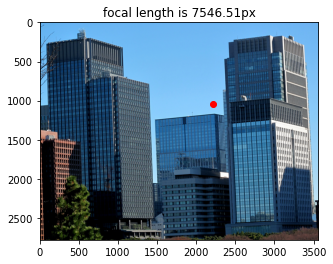

In [7]:
# res03
plt.title(f'focal length is {f:.2f}px')
plt.imshow(img_o)
plt.scatter(p[0], p[1], c='r')
plt.show()

In [8]:
K = np.array([[f, 0, p[0]],
              [0, f, p[1]],
              [0, 0, 1]])
Ki = np.linalg.inv(K)

nrm = np.cross(Ki @ vx, Ki @ vy)
nrm /= np.linalg.norm(nrm[:2])
zrd = np.arctan2(nrm[1], nrm[0]) + np.pi / 2
xrd = np.arcsin(nrm[2] / np.linalg.norm(nrm))
print('rotation on z:', np.rad2deg(-zrd))
print('rotation on x:', np.rad2deg(xrd))




rotation on z: 2.8100066736062552
rotation on x: 6.636910115320531
